In [1]:
from pagn import Thompson
from pagn import Sirko
import numpy as np
import matplotlib.pyplot as plt
import pagn.constants as ct
plt.rcParams['figure.dpi'] = 150
from IPython.display import clear_output

/home/olga/anaconda3/lib/python3.9/site-packages/pagn/opacities.py:12: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy.interpolate import RectBivariateSpline


In [2]:
#MIGRATION TORQUES

from scipy.interpolate import UnivariateSpline
from pagn.opacities import electron_scattering_opacity
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

def gamma_0(q, hr, Sigma, r, Omega):
    """
    Method to find the normalization torque

    Parameters
    ----------
    q: float/array
        Float or array representing the mass ratio between the migrator and the central BH.
    hr: float/array
        Float or array representing the disk height to distance from central BH ratio.
    Sigma: float/array
        Float or array representing the disk surface density in kg/m^2
    r: float/array
        Float or array representing the distance from the central BH in m
    Omega: float/array
        Float or array representing the angular velocity at the migrator position in SI units.

    Returns
    -------
    gamma_0: float/array
        Float or array representing the single-arm migration torque on the migrator in kg m^2/ s^2.

    """
    gamma_0 = q*q*Sigma*r*r*r*r*Omega*Omega/(hr*hr)     
    return gamma_0


def gamma_iso(dSigmadR, dTdR):
    """
    Method to find the locally isothermal torque.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.

    Returns
    -------
    gamma_iso: float/array
        Float or array representing the locally isothermal torque on the migrator in kg m^2/ s^2.

    """
    alpha = - dSigmadR
    beta = - dTdR
    gamma_iso = - 0.85 - alpha - 0.9*beta
    return gamma_iso


def gamma_ad(dSigmadR, dTdR):
    """
    Method to find the adiabatic torque.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.

    Returns
    -------
    gamma_ad: float/array
        Float or array representing the adabiatic torque on the migrator in kg m^2/ s^2.

    """
    alpha = - dSigmadR
    beta = - dTdR
    gamma = 5/3
    xi = beta - (gamma - 1)*alpha
    gamma_ad = - 0.85 - alpha - 1.7*beta + 7.9*xi/gamma
    return gamma_ad


def dSigmadR(obj):
    """
    Method that interpolates the surface density gradient of an AGN disk object.

    Parameters
    ----------
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.

    Returns
    -------
    dSigmadR: float/array
        Discrete array of the log surface density gradient.

    """
    Sigma = 2*obj.rho*obj.h # descrete
    rlog10 = np.log10(obj.R)  # descrete
    Sigmalog10 = np.log10(Sigma)  # descrete
    Sigmalog10_spline = UnivariateSpline(rlog10, Sigmalog10, k=3, s=0.005, ext=0)  # need scipy ver 1.10.0
    dSigmadR_spline =  Sigmalog10_spline.derivative()
    dSigmadR = dSigmadR_spline(rlog10)
    return dSigmadR


def dTdR(obj):
    """
    Method that interpolates the thermal gradient of an AGN disk object.

    Parameters
    ----------
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.

    Returns
    -------
    dTdR: float/array
        Discrete array of the log thermal gradient.

    """
    rlog10 = np.log10(obj.R)  # descrete
    Tlog10 = np.log10(obj.T)  # descrete
    Tlog10_spline = UnivariateSpline(rlog10, Tlog10, k=3, s=0.005, ext=0)  # need scipy ver 1.10.0
    dTdR_spline = Tlog10_spline.derivative()
    dTdR = dTdR_spline(rlog10)
    return dTdR


def dPdR(obj):
    """
    Method that interpolates the total pressure gradient of an AGN disk object.

    Parameters
    ----------
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.

    Returns
    -------
    dPdR: float/array
        Discrete array of the log total pressure gradient.

    """
    rlog10 = np.log10(obj.R)  # descrete
    pgas = obj.rho * obj.T * ct.Kb / ct.massU
    prad = obj.tauV*ct.sigmaSB*obj.Teff4/(2*ct.c)
    ptot = pgas + prad
    Plog10 = np.log10(ptot)  # descrete
    Plog10_spline = UnivariateSpline(rlog10, Plog10, k=3, s=0.005, ext=0)  # need scipy ver 1.10.0
    dPdR_spline = Plog10_spline.derivative()
    dPdR = dPdR_spline(rlog10)
    return dPdR


def CI_p10(dSigmadR, dTdR):
    """
    Method to calculate torque coefficient for the Paardekooper et al. 2010 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.

    Returns
    -------
    cI: float/array
        Paardekooper et al. 2010 migration torque coefficient
    """
    cI = -0.85 + 0.9*dTdR + dSigmadR
    return cI


def CI_jm17_tot(dSigmadR, dTdR, gamma, obj):
    """
    Method to calculate torque coefficient for the Jiménez and Masset 2017 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.
    gamma: float
        Adiabatic index
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.


    Returns
    -------
    cI: float/array
        Jiménez and Masset 2017 migration torque coefficient
    """
    cL = CL(dSigmadR, dTdR, gamma, obj)
    cI = cL + (0.46 + 0.96*dSigmadR - 1.8*dTdR)/gamma
    return cI


def CI_jm17_iso(dSigmadR, dTdR):
    """
    Method to calculate the locally isothermal torque coefficient for the Jiménez and Masset 2017 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.

    Returns
    -------
    cI: float/array
        Jiménez and Masset 2017 migration locally isothermal torque coefficient
    """
    cI = -1.36 + 0.54*dSigmadR + 0.5*dTdR
    return cI


def CL(dSigmadR, dTdR, gamma, obj):
    """
    Method to calculate the Lindlblad torque for the Jiménez and Masset 2017 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.
    gamma: float
        Adiabatic index
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.


    Returns
    -------
    cL: float/array
        Jiménez and Masset 2017 Lindblad torque coefficient
    """
    xi = 16*gamma*(gamma - 1)*ct.sigmaSB*(obj.T*obj.T*obj.T*obj.T)\
         /(3*obj.kappa*obj.rho*obj.rho*obj.h*obj.h*obj.Omega*obj.Omega)
    x2_sqrt = np.sqrt(xi/(2*obj.h*obj.h*obj.Omega))
    fgamma = (x2_sqrt + 1/gamma)/(x2_sqrt+1)
    cL = (-2.34 - 0.1*dSigmadR + 1.5*dTdR)*fgamma
    return cL


def gamma_thermal(gamma, obj, q):
    """
    Method to calculate the thermal torque from the Masset 2017 equations, with decay and torque saturation.

    Parameters
    ----------
    gamma: float
        Adiabatic index
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.
    q: float/array
        Float or array representing the mass ratio between the migrator and the central BH.

    Returns
    -------
    g_thermal: float/array
        Masset 2017 migration total thermal torque.
    """
    xi = 16 * gamma * (gamma - 1) * ct.sigmaSB * (obj.T * obj.T * obj.T * obj.T) \
         / (3 * obj.kappa * obj.rho * obj.rho * obj.h * obj.h * obj.Omega * obj.Omega)
    mbh = obj.Mbh*q
    muth = xi * obj.cs / (ct.G * mbh)
    R_Bhalf = ct.G*mbh/obj.cs**2
    muth[obj.h<R_Bhalf] = (xi / (obj.cs*obj.h))[obj.h<R_Bhalf]

    Lc = 4*np.pi*ct.G*mbh*obj.rho*xi/gamma
    lam = np.sqrt(2*xi/(3*gamma*obj.Omega))

    dP = -dPdR(obj)
    xc = dP*obj.h*obj.h/(3*gamma*obj.R)

    kes = electron_scattering_opacity(X=0.7)
    L = 4 * np.pi * ct.G * ct.c * mbh / kes

    g_hot = 1.61*(gamma - 1)*xc*L/(Lc*gamma*lam)
    g_cold = -1.61*(gamma - 1)*xc/(gamma*lam)
    g_thermal = g_hot + g_cold
    g_thermal_new = g_hot*(4*muth/(1+4*muth)) + g_cold*(2*muth/(1+2*muth))
    g_thermal[muth < 1] = g_thermal_new[muth < 1]
    decay = 1 - np.exp(-lam*obj.tauV/obj.h)
    return g_thermal*decay

def Kappa(q, hr, alpha):
    
    """
    Method to find the correction for type II torque

    Parameters
    ----------
    q: float/array
        Float or array representing the mass ratio between the migrator and the central BH.
    hr: float/array
        Float or array representing the disk height to distance from central BH ratio.
    alpha: Shakura-Sunyaev viscosity constant

    Returns
    -------
    K: float/array
        Float or array representing correction that takes into account the lower but non-zero density of gas in the gap.

    """
    
    K = q*q/(alpha*hr*hr*hr*hr*hr)
    
    return K/25

# Type II
Let's plot the type I, thermal and total torque from Grishin et al using original pAGN.

1) M$_{SMBH} = 10^{7} $ M$_{\odot}$
2) M$sBH$ = 10 M$_{\odot}$

$\rightarrow q = 10^{-6}$

Type II torque is:

$$\Gamma_0 = q^2 r^4 \Omega^2 \Sigma_I (\frac{h}{r})^{-3} $$

which is definite positive. With a correction from Jimenez et al

$$\Gamma_I = C_I \frac{h}{r} \Gamma_0 = C_I q^2 r^4 \Omega^2 \Sigma (\frac{h}{r})^{-2} $$

the factor $C_I \sim -2.5$ is definite negative so the total torque is negative $\rightarrow$ inward migration!

Thermal torque is instead:

$$\Gamma_{therm,I} = \Gamma_{hot}' + \Gamma_{cold}'  $$

and can be positive or negative.

Total torque for type I migration is $$ \Gamma_{tot,I} = \Gamma_I + \Gamma_{therm,I} $$

and can be negative  $\rightarrow$ inward migration, or positive $\rightarrow$ outward migration

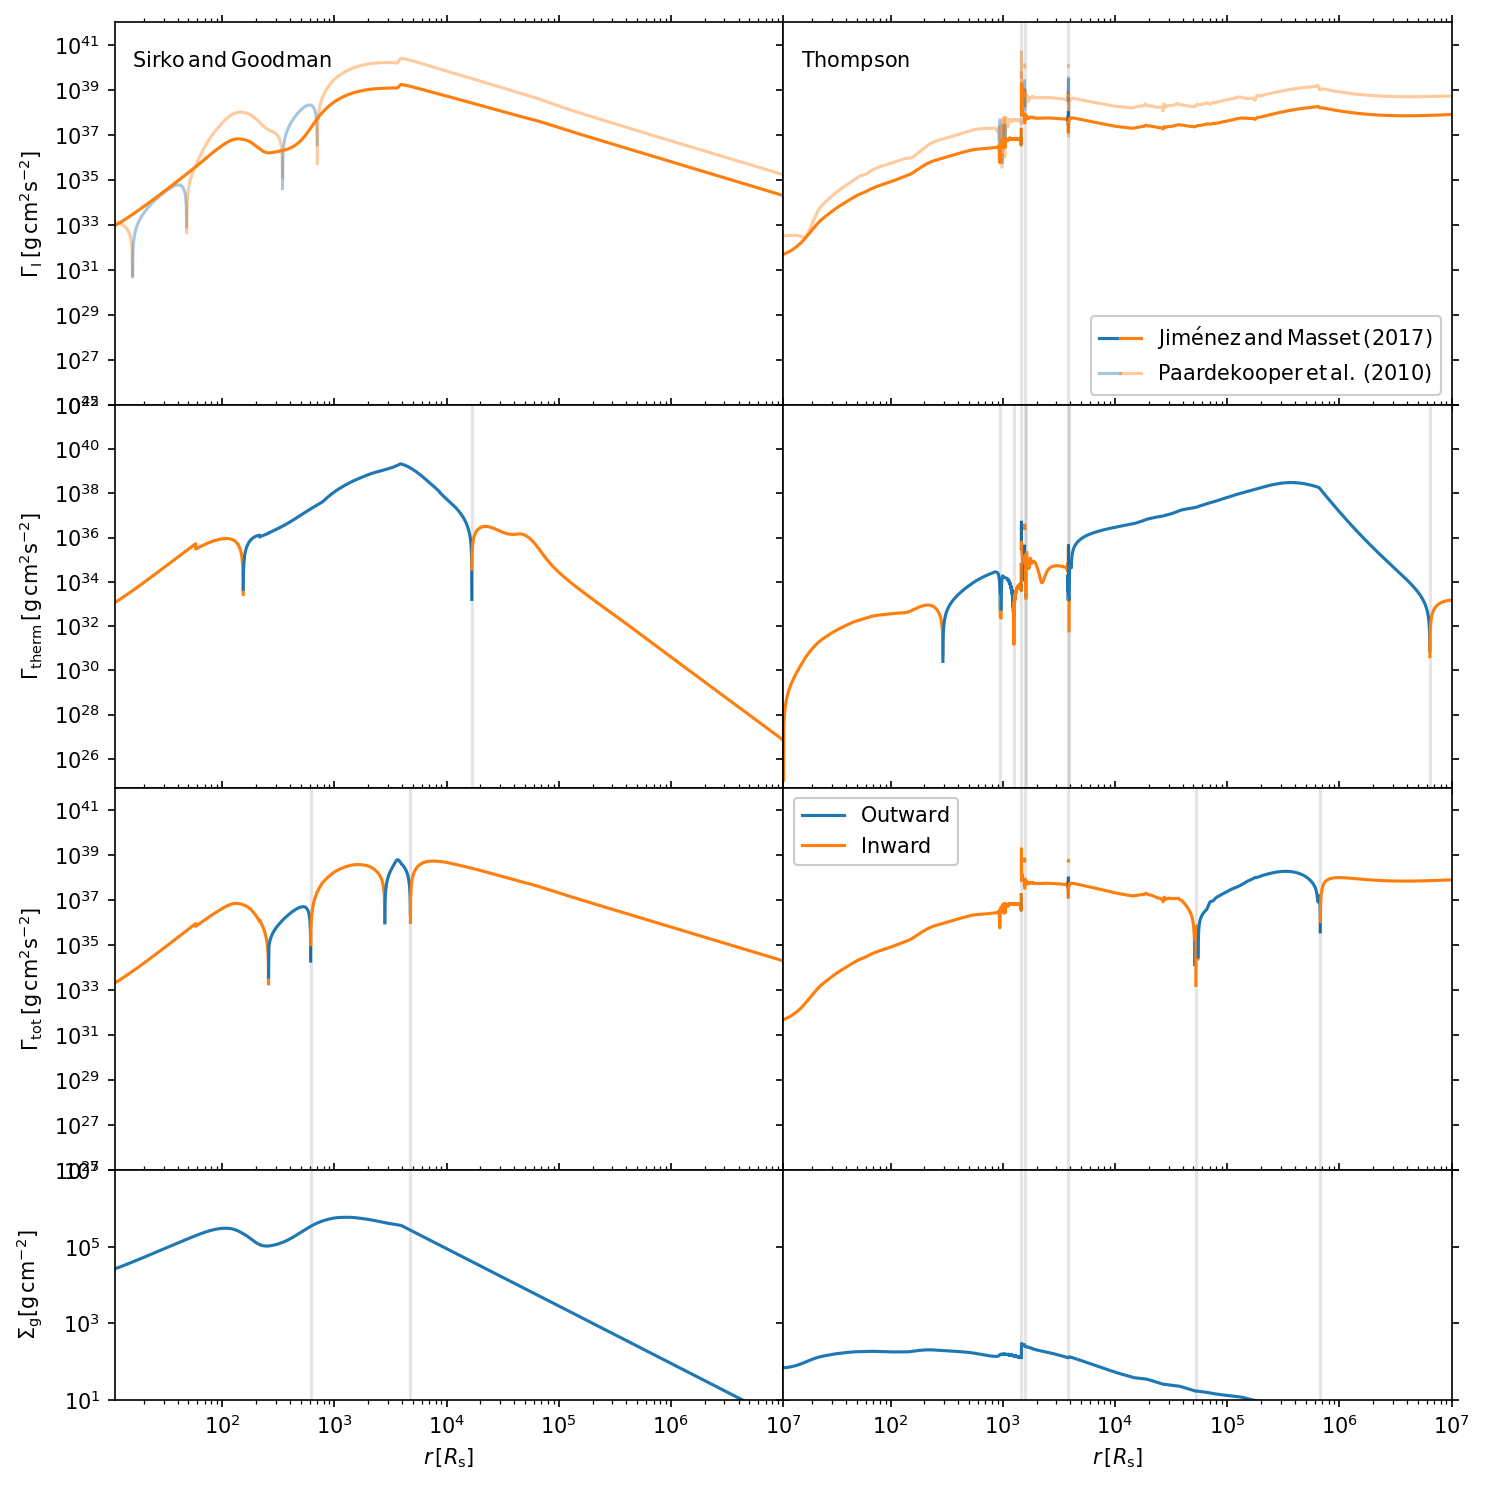

In [3]:
from IPython.display import clear_output

disk_name = ['sirko', 'thompson']
d_counter = 0

f, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey='row', gridspec_kw=dict(hspace=0, wspace =0, height_ratios = (2, 2, 2, 1.2)), tight_layout=True)
for axx in axes.flatten():
    axx.set_yscale('log')
    axx.set_xscale('log')

for dname in disk_name:
    Mbh = 1e7
    q = 1e-6

    #generate the disk values for both AGN disk models using pagn
    if dname == 'thompson':
        objin = Thompson.ThompsonAGN(Mbh = Mbh*ct.MSun, Mdot_out=0.,)
        rout = objin.Rs*(1e7)
        sigma = 200 * (Mbh / 1.3e8) ** (1 / 4.24)
        Mdot_out = 1.5e-2
        obj = Thompson.ThompsonAGN(Mbh=Mbh*ct.MSun, Rout = rout, Mdot_out=Mdot_out*ct.MSun/ct.yr)
        clear_output(obj.solve_disk(N=1e4))
    else:
        le = 0.5
        alpha = 0.01
        obj = Sirko.SirkoAGN(Mbh=Mbh*ct.MSun, le=le, alpha=alpha, b=0)
        clear_output(obj.solve_disk(N=1e4))

    Gamma_0 = gamma_0(q, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    #Grishin et al 2023 equations
    dSig = dSigmadR(obj)
    dT = dTdR(obj)
    cI_p10 = CI_p10(dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    gamma = 5/3

    cI_jm_tot = CI_jm17_tot(dSig, dT, gamma, obj)
    Gamma_I_jm_tot = cI_jm_tot*Gamma_0
    Gamma_therm = gamma_thermal(gamma, obj, q)*Gamma_0*obj.R/obj.h

    Gamma_tot = Gamma_therm + Gamma_I_jm_tot

    #-----Plotting-----#


    linestyles = ['-', '--', '-.', ':']
    ax = axes[:, d_counter]
    if hasattr(obj, 'alpha'):
        ax[0].text(10 ** 1.2, 10 ** 40,  r'${\rm Sirko \, and \, Goodman}$' )
    else:
        ax[0].text(10 ** 1.2, 10 ** 40,  r'${\rm Thompson}$')

    for iGamma, Gamma in enumerate([Gamma_I_jm_tot, Gamma_therm, Gamma_tot]):
        maskg = Gamma >= 0
        indices = np.nonzero(maskg[1:] != maskg[:-1])[0] + 1
        Gammas = np.split(Gamma, indices)
        Rs = np.split(obj.R, indices)
        ignnum = 0
        ignum2 = 0
        for iseg, seg in enumerate(Gammas):
            if seg[0] < 0.:
                if Rs[iseg][0] / obj.Rs > ignnum + 40:
                    ax[iGamma].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color = 'k', alpha = 0.1)
                    ignnum = Rs[iseg][0] / obj.Rs

                ax[iGamma].plot(Rs[iseg]/obj.Rs, abs(seg)*ct.SI_to_gcm2, c='C1', zorder = 2)
                if iGamma == 2 and Rs[iseg][0] / obj.Rs > ignum2 + 40:
                    ax[3].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color='k', alpha=0.1)
                    ignum2 = Rs[iseg][0] / obj.Rs

            else:
                ax[iGamma].plot(Rs[iseg] / obj.Rs, abs(seg*ct.SI_to_gcm2) , c='C0', zorder = 2)
        if iGamma == 0:
            Gamma2 = Gamma_I_p10
            maskg2 = Gamma2 >= 0
            indices2 = np.nonzero(maskg2[1:] != maskg2[:-1])[0] + 1
            Gammas2 = np.split(Gamma2, indices2)
            Rs2 = np.split(obj.R, indices2)
            for iseg2, seg2 in enumerate(Gammas2):
                if seg2[0] < 0.:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C1', zorder = 1, alpha = 0.4)

                else:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C0', zorder = 1, alpha = 0.4)
    ax[3].plot(obj.R/obj.Rs, 2*obj.h*obj.rho*ct.SI_to_gcm2, label = r"$\Sigma_{\rm g} [{\rm g cm}^{-2}]$")
    d_counter += 1

pos_line = mlines.Line2D([], [], color='C0', marker='s',
                           markersize=0, label=r'$\rm{Outward}$')
neg_line = mlines.Line2D([], [], color='C1', marker='s',
                            markersize=0, label=r'$\rm{Inward}$')
artists_handles = [pos_line, neg_line]
axes[2, 1].legend(handles=artists_handles, framealpha = 1)

pos_line2 = mlines.Line2D([], [], color='C0', marker='s', alpha = 0.4,
                         markersize=0,)
neg_line2 = mlines.Line2D([], [], color='C1', marker='s', alpha = 0.4,
                         markersize=0,)

from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
axes[0,1].legend(handles=[(pos_line, neg_line), (pos_line2, neg_line2,) ],
                 labels=[r'${\rm Jim \acute{e} nez \, and \, Masset \, (2017)}$', r'$\rm Paardekooper \, et \, al. \, (2010)$',],
                 handler_map = {tuple: HandlerTuple(ndivide = None, pad = 0.)},
                 framealpha = 1)

axes[0,0].set_ylabel(r'${\Gamma_{\rm I} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[1,0].set_ylabel(r'${\Gamma_{\rm therm} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[2,0].set_ylabel(r'${\Gamma_{\rm tot} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[3, 0].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

x_label = r"$r \, [R_{\rm s}]$"
axes[3, 0].set_xlabel(x_label)
axes[3, 1].set_xlabel(x_label)

axes[0, 0].set_ylim((1e25, 1e42))


axes[1, 0].set_ylim((5e24, 1e42))

axes[2, 0].set_ylim((1e25, 1e42))


axes[3, 0].set_ylim((1e1, 1e7))

for axx in axes.flatten():
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.set_xlim((1e1, 1e7))
axes[0,1].set_xlim((1.1e1, 1e7))

f.align_ylabels()
plt.show()

# Type II

Let's now plot type II and thermal torque exerted by the same disk but on a massive bh, in particular:

1) M$_{SMBH} = 10^{7} $ M$_{\odot}$
2) M$IMBH = 10^{3}$ M$_{\odot}$

$\rightarrow q_{II} = 10^{-4}$ I only need to change this because the other parameters depend on the disc model so they are fixed.

I expect type II migration to be negative, with the IMBH fast migrating inward.

But I have 2 different prescription: Kanagawa and Gilbaum

Kanagawa et al:

$$\Gamma_{II} \simeq -0.4 q^2 r^4 \Omega^2 \Sigma_{II} (\frac{h}{r})^{-3}$$

where $$\Sigma_{II} = \frac{\Sigma_I}{1 + K/25} $$ and $$ K = q^2 (\frac{h}{r})^{-5} \alpha^{-1} $$

so the type II torque reduces to

$$\Gamma_{II} \simeq \frac{-0.4}{1 + K/25} \Gamma_0$$

Since $K \propto q^2$ and also $\Gamma_0 \propto q^2$ type II torque is independent on the mass of the satellite orbiting the supermassive black hole.

From Gilbaum:

$$ \Gamma_{II} = \frac{C_{II}}{C_I} \frac{1}{1 + K/25} \Gamma_I $$

that reduces to

$$ \Gamma_{II} = \frac{C_{II}}{1 + K/25} \Gamma_0 $$

But now I have $K \geq 0$, $\Gamma_0 \geq 0$ and they use $C_{II} = 1 \geq 0 \rightarrow$ outward migration. 
If instead I use $C_{II} = -1$ I recover the inward migration. Or maybe it's

$$ \Gamma_{II} = \frac{C_{II}}{C_I} \frac{1}{1 + K/25} \Gamma_0 $$

in this way, if $C_I \sim -2.5$ from Jimenez and $C_{II} = 1 \rightarrow \frac{C_{II}}{C_I} \sim -0.4$ like the one used by Kanagawa.

Finally 

$$ \Gamma_{tot,II} = \Gamma_{II} + \Gamma_{therm,II} $$

## Gilbaum et al
Prescription with $C_{II} = 1 \rightarrow$ outward migration

-2.0559846314407593
-2.5477527963593025


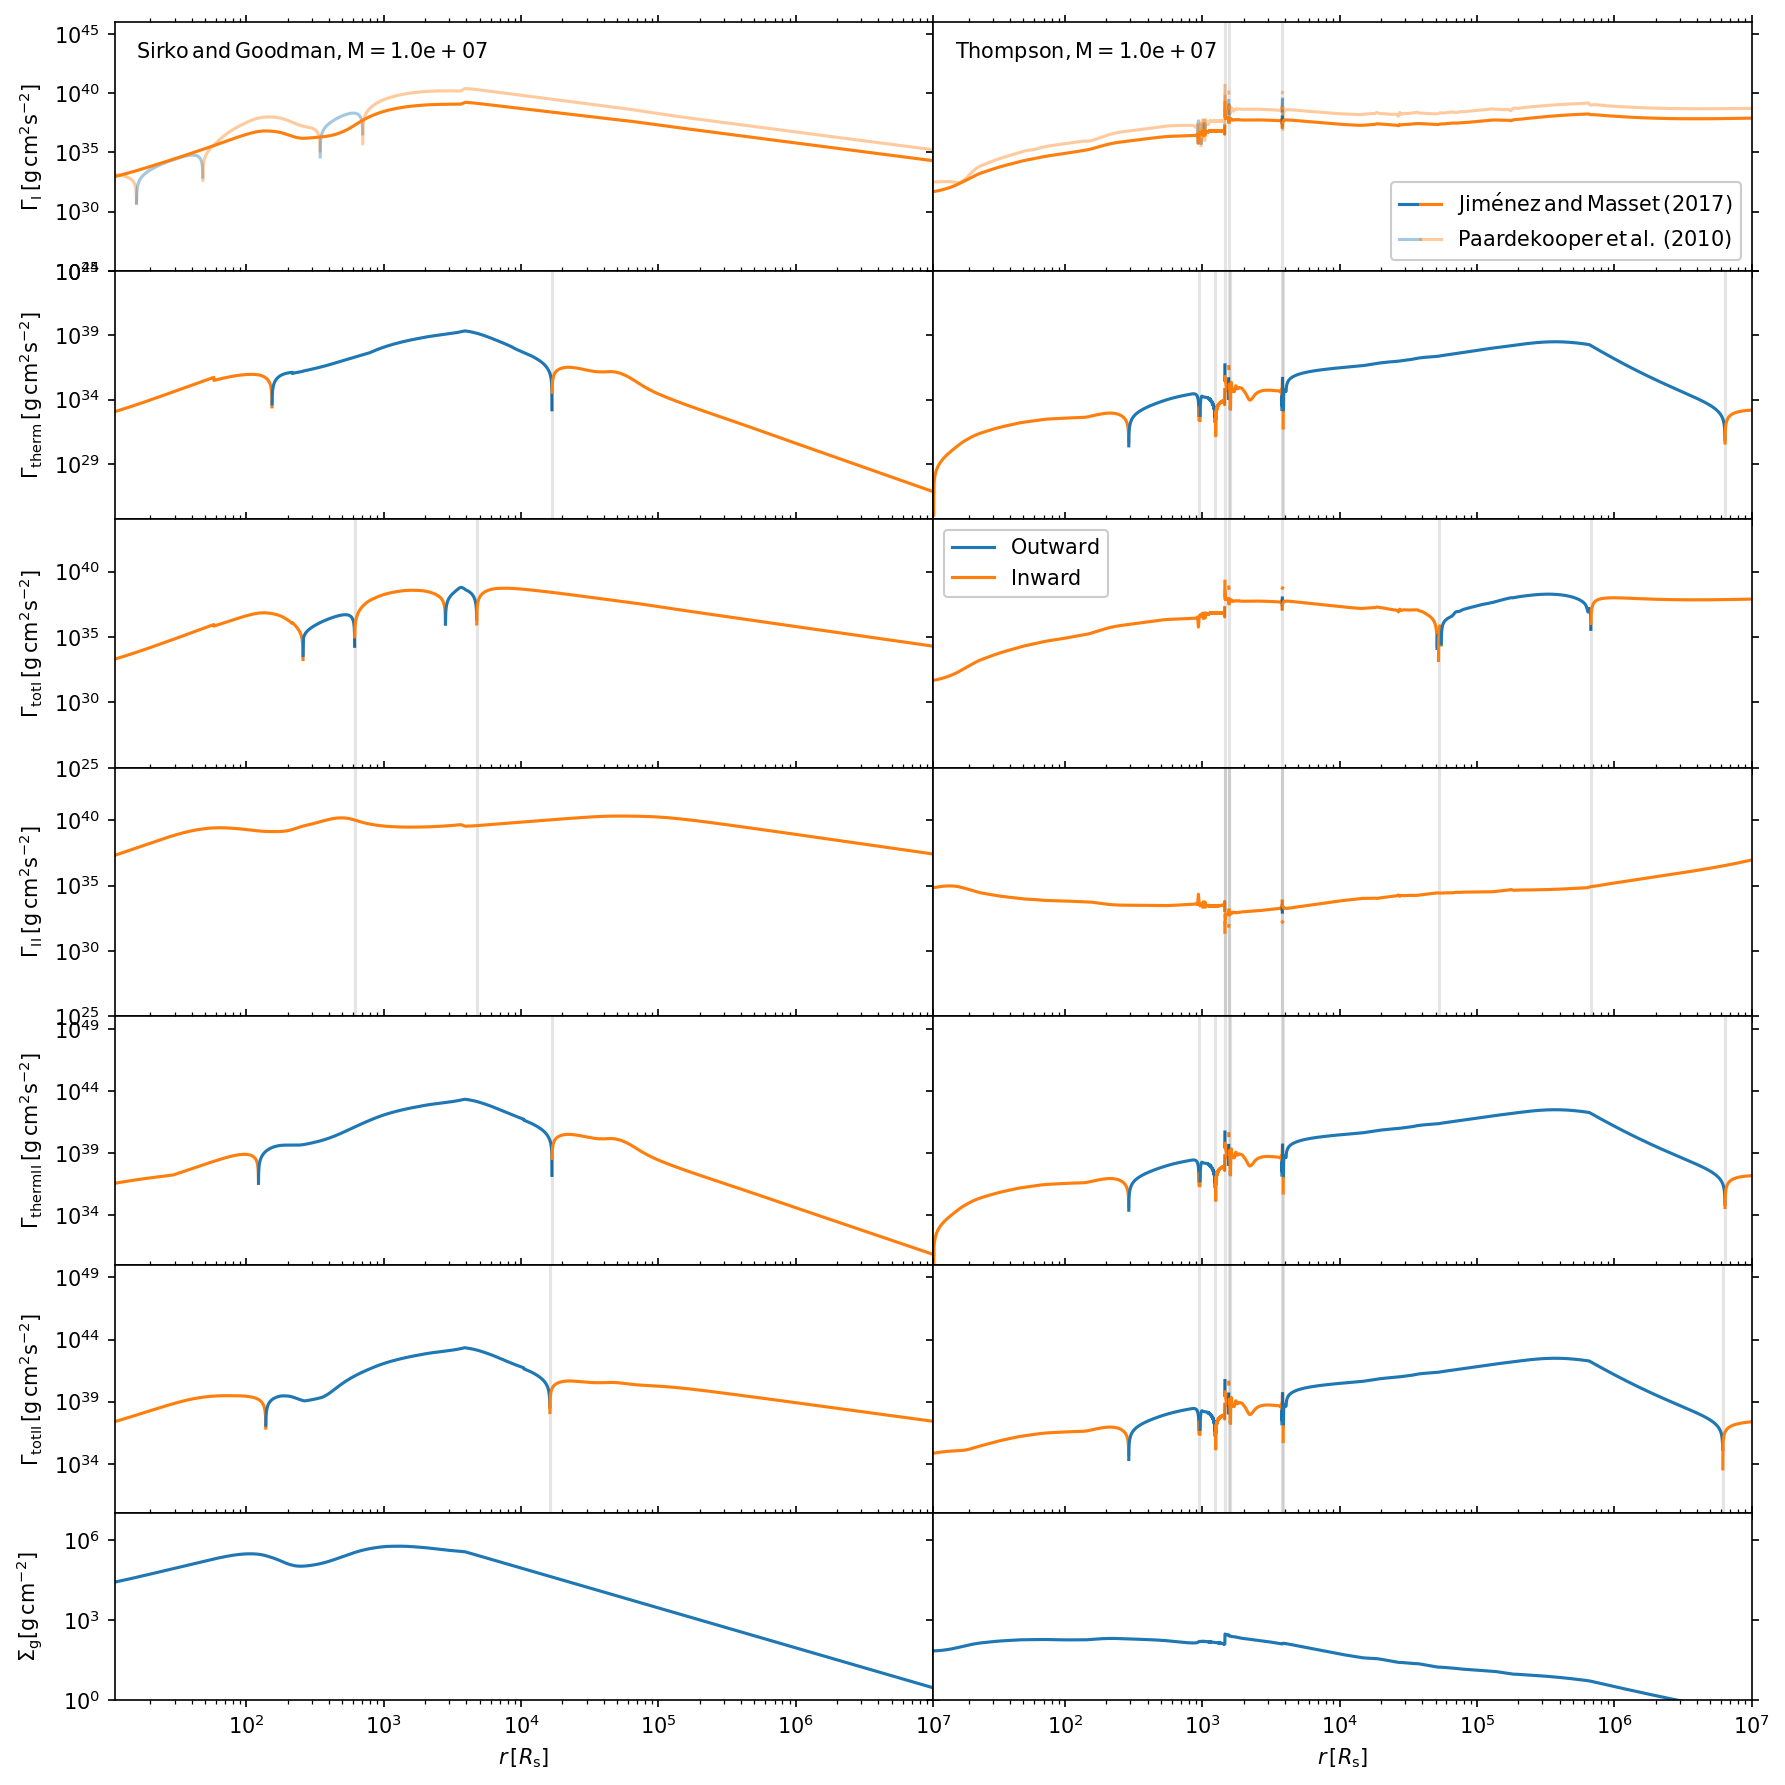

In [4]:
disk_name = ['sirko', 'thompson']
d_counter = 0

f, axes = plt.subplots(7, 2, figsize=(12, 12), sharex=True, sharey='row', gridspec_kw=dict(hspace=0, wspace =0, height_ratios = (2, 2, 2, 2, 2, 2, 1.5)), tight_layout=True)
for axx in axes.flatten():
    axx.set_yscale('log')
    axx.set_xscale('log')

for dname in disk_name:
    Mbh = 1e7
    q = 1e-6
    q_II = 1e-4

    #generate the disk values for both AGN disk models using pagn
    if dname == 'thompson':
        objin = Thompson.ThompsonAGN(Mbh = Mbh*ct.MSun, Mdot_out=0.,)
        rout = objin.Rs*(1e7)
        sigma = 200 * (Mbh / 1.3e8) ** (1 / 4.24)
        Mdot_out = 1.5e-2
        obj = Thompson.ThompsonAGN(Mbh=Mbh*ct.MSun, Rout = rout, Mdot_out=Mdot_out*ct.MSun/ct.yr)
        print('tho:', Mbh)
        clear_output(obj.solve_disk(N=1e4))
    else:
        le = 0.5
        alpha = 0.01
        obj = Sirko.SirkoAGN(Mbh=Mbh*ct.MSun, le=le, alpha=alpha, b=0)
        print('sk:', Mbh)
        clear_output(obj.solve_disk(N=1e4))

    Gamma_0 = gamma_0(q, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    #Grishin et al 2023 equations q=1e-6
    dSig = dSigmadR(obj)
    dT = dTdR(obj)
    cI_p10 = CI_p10(dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    gamma = 5/3
    print(np.mean(cI_p10))

    cI_jm_tot = CI_jm17_tot(dSig, dT, gamma, obj)
    Gamma_I_jm_tot = cI_jm_tot*Gamma_0
    Gamma_therm = gamma_thermal(gamma, obj, q)*Gamma_0*obj.R/obj.h
    print(np.mean(cI_jm_tot))
    
    Gamma_tot_I = Gamma_therm + Gamma_I_jm_tot
    
    #Gilbaum eq but for type II, so q=1e-4
    Gamma_0_II = gamma_0(q_II, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    Gamma_I_p10_II = cI_p10*Gamma_0_II
    gamma = 5/3

    Gamma_I_jm_tot_II = cI_jm_tot*Gamma_0_II
    Gamma_therm_II = gamma_thermal(gamma, obj, q_II)*Gamma_0_II*obj.R/obj.h
    
    c_II_gil = 1
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_gil = c_II_gil/cI_jm_tot*1/(1 + kappa)
    Gamma_II_gil = const_gil*Gamma_0_II #Gamma_I_jm_tot_II
    
    
    #Kanagawa
    c_II_K = -0.4 
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_fact_K = c_II_K*1/(1 + kappa)
    
    Gamma_II_K = const_fact_K*Gamma_0_II

    
    Gamma_tot_II = Gamma_therm_II + Gamma_II_gil

    #-----Plotting-----#


    linestyles = ['-', '--', '-.', ':']
    ax = axes[:, d_counter]
    if hasattr(obj, 'alpha'):
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Sirko \, and \, Goodman, M = 'f"{Mbh:.1e}"'}$' )
    else:
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Thompson, M = 'f"{Mbh:.1e}"'}$')

    for iGamma, Gamma in enumerate([Gamma_I_jm_tot, Gamma_therm, Gamma_tot_I, Gamma_II_gil, Gamma_therm_II, Gamma_tot_II]):
        maskg = Gamma >= 0
        indices = np.nonzero(maskg[1:] != maskg[:-1])[0] + 1
        Gammas = np.split(Gamma, indices)
        Rs = np.split(obj.R, indices)
        ignnum = 0
        ignum2 = 0
        for iseg, seg in enumerate(Gammas):
            if seg[0] < 0.:
                if Rs[iseg][0] / obj.Rs > ignnum + 40:
                    ax[iGamma].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color = 'k', alpha = 0.1)
                    ignnum = Rs[iseg][0] / obj.Rs

                ax[iGamma].plot(Rs[iseg]/obj.Rs, abs(seg)*ct.SI_to_gcm2, c='C1', zorder = 2)
                if iGamma == 2 and Rs[iseg][0] / obj.Rs > ignum2 + 40:
                    ax[3].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color='k', alpha=0.1)
                    ignum2 = Rs[iseg][0] / obj.Rs

            else:
                ax[iGamma].plot(Rs[iseg] / obj.Rs, abs(seg*ct.SI_to_gcm2) , c='C0', zorder = 2)
        if iGamma == 0:
            Gamma2 = Gamma_I_p10
            maskg2 = Gamma2 >= 0
            indices2 = np.nonzero(maskg2[1:] != maskg2[:-1])[0] + 1
            Gammas2 = np.split(Gamma2, indices2)
            Rs2 = np.split(obj.R, indices2)
            for iseg2, seg2 in enumerate(Gammas2):
                if seg2[0] < 0.:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C1', zorder = 1, alpha = 0.4)

                else:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C0', zorder = 1, alpha = 0.4)
    ax[6].plot(obj.R/obj.Rs, 2*obj.h*obj.rho*ct.SI_to_gcm2, label = r"$\Sigma_{\rm g} [{\rm g cm}^{-2}]$")
    d_counter += 1

pos_line = mlines.Line2D([], [], color='C0', marker='s',
                           markersize=0, label=r'$\rm{Outward}$')
neg_line = mlines.Line2D([], [], color='C1', marker='s',
                            markersize=0, label=r'$\rm{Inward}$')
artists_handles = [pos_line, neg_line]
axes[2, 1].legend(handles=artists_handles, framealpha = 1)

pos_line2 = mlines.Line2D([], [], color='C0', marker='s', alpha = 0.4,
                         markersize=0,)
neg_line2 = mlines.Line2D([], [], color='C1', marker='s', alpha = 0.4,
                         markersize=0,)


axes[0,1].legend(handles=[(pos_line, neg_line), (pos_line2, neg_line2,) ],
                 labels=[r'${\rm Jim \acute{e} nez \, and \, Masset \, (2017)}$', r'$\rm Paardekooper \, et \, al. \, (2010)$',],
                 handler_map = {tuple: HandlerTuple(ndivide = None, pad = 0.)},
                 framealpha = 1)

axes[0,0].set_ylabel(r'${\Gamma_{\rm I} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[1,0].set_ylabel(r'${\Gamma_{\rm therm} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[2,0].set_ylabel(r'${\Gamma_{\rm totI} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[3, 0].set_ylabel(r'${\Gamma_{\rm II} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[4,0].set_ylabel(r'${\Gamma_{\rm thermII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[5, 0].set_ylabel(r'${\Gamma_{\rm totII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[6, 0].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

x_label = r"$r \, [R_{\rm s}]$"
axes[6, 0].set_xlabel(x_label)
axes[6, 1].set_xlabel(x_label)

axes[0, 0].set_ylim((1e25, 1e46))

axes[1, 0].set_ylim((5e24, 1e44))

axes[2, 0].set_ylim((1e25, 1e44))

axes[3, 0].set_ylim((1e25, 1e44))

axes[4, 0].set_ylim((1e30, 1e50))

axes[5, 0].set_ylim((1e30, 1e50))

axes[6, 0].set_ylim((1e0, 1e7))

for axx in axes.flatten():
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.set_xlim((1e1, 1e7))
axes[0,1].set_xlim((1.1e1, 1e7))

f.align_ylabels()
plt.show()

## Gilbaum et al
Prescription with $C_{II} = -1 \rightarrow$ inward migration!

-2.0559846314407593
-2.5477527963593025


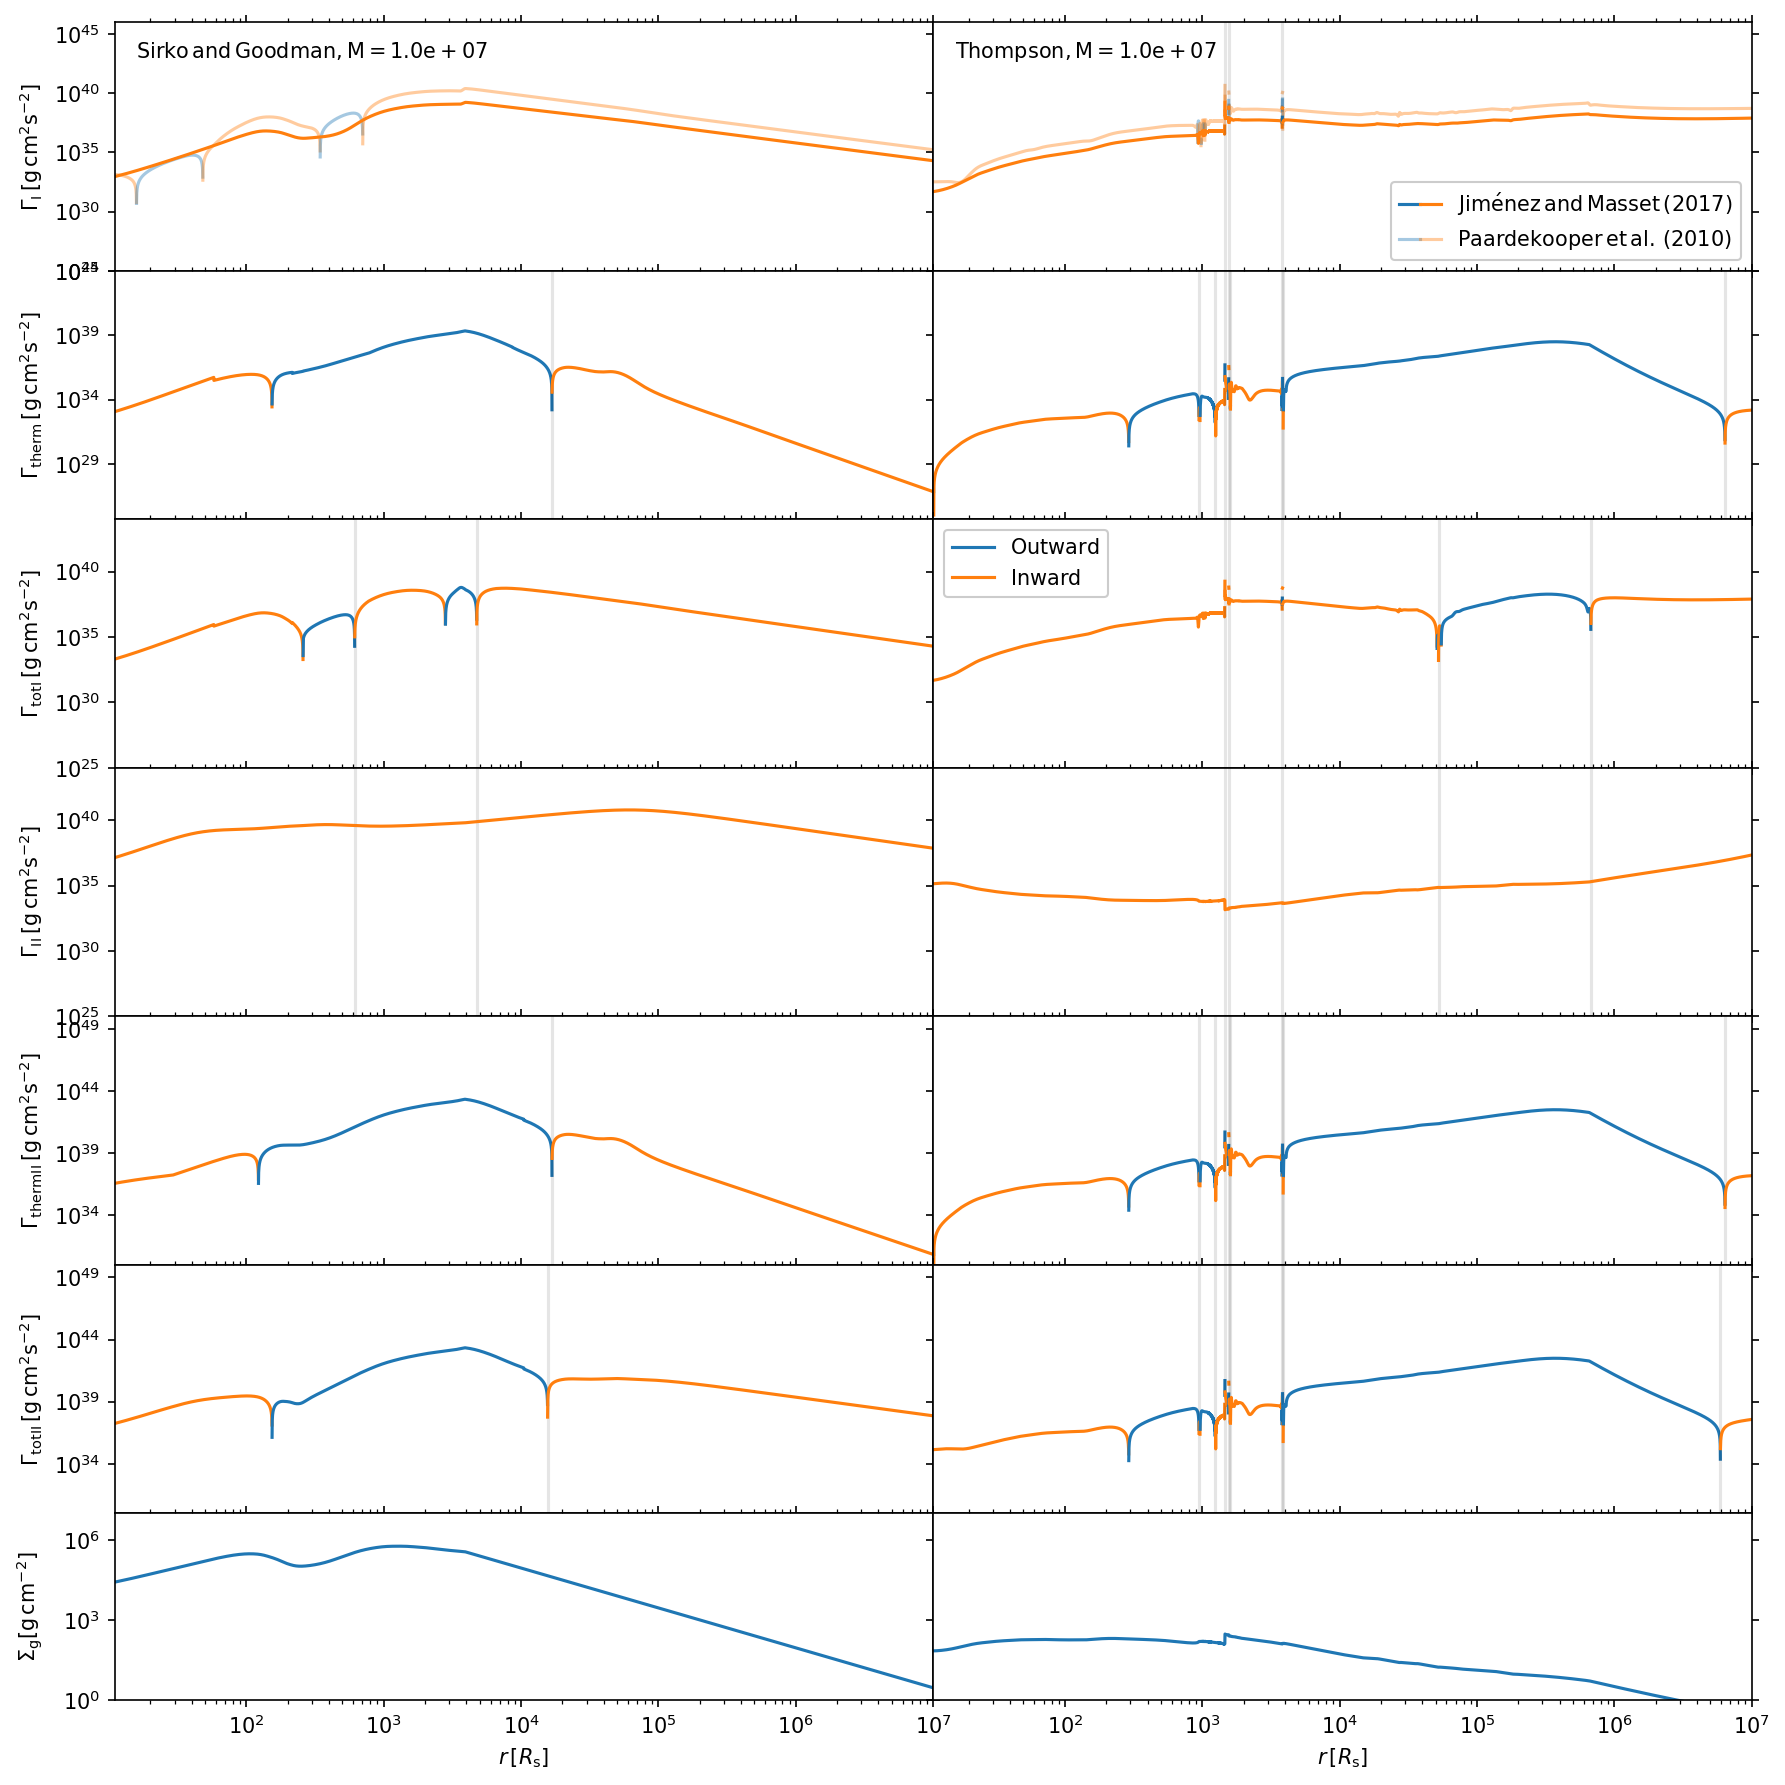

In [5]:
disk_name = ['sirko', 'thompson']
d_counter = 0

f, axes = plt.subplots(7, 2, figsize=(12, 12), sharex=True, sharey='row', gridspec_kw=dict(hspace=0, wspace =0, height_ratios = (2, 2, 2, 2, 2, 2, 1.5)), tight_layout=True)
for axx in axes.flatten():
    axx.set_yscale('log')
    axx.set_xscale('log')

for dname in disk_name:
    Mbh = 1e7
    q = 1e-6
    q_II = 1e-4

    #generate the disk values for both AGN disk models using pagn
    if dname == 'thompson':
        objin = Thompson.ThompsonAGN(Mbh = Mbh*ct.MSun, Mdot_out=0.,)
        rout = objin.Rs*(1e7)
        sigma = 200 * (Mbh / 1.3e8) ** (1 / 4.24)
        Mdot_out = 1.5e-2
        obj = Thompson.ThompsonAGN(Mbh=Mbh*ct.MSun, Rout = rout, Mdot_out=Mdot_out*ct.MSun/ct.yr)
        print('tho:', Mbh)
        clear_output(obj.solve_disk(N=1e4))
    else:
        le = 0.5
        alpha = 0.01
        obj = Sirko.SirkoAGN(Mbh=Mbh*ct.MSun, le=le, alpha=alpha, b=0)
        print('sk:', Mbh)
        clear_output(obj.solve_disk(N=1e4))

    Gamma_0 = gamma_0(q, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    #Grishin et al 2023 equations q=1e-6
    dSig = dSigmadR(obj)
    dT = dTdR(obj)
    cI_p10 = CI_p10(dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    gamma = 5/3
    print(np.mean(cI_p10))

    cI_jm_tot = CI_jm17_tot(dSig, dT, gamma, obj)
    Gamma_I_jm_tot = cI_jm_tot*Gamma_0
    Gamma_therm = gamma_thermal(gamma, obj, q)*Gamma_0*obj.R/obj.h
    print(np.mean(cI_jm_tot))
    
    Gamma_tot_I = Gamma_therm + Gamma_I_jm_tot
    
    #Gilbaum eq but for type II, so q=1e-4
    Gamma_0_II = gamma_0(q_II, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    Gamma_I_p10_II = cI_p10*Gamma_0_II
    gamma = 5/3

    Gamma_I_jm_tot_II = cI_jm_tot*Gamma_0_II
    Gamma_therm_II = gamma_thermal(gamma, obj, q_II)*Gamma_0_II*obj.R/obj.h
    
    c_II_gil = -1
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_gil = c_II_gil/cI_jm_tot*1/(1 + kappa)
    Gamma_II_gil = const_gil*Gamma_I_jm_tot_II
    
    
    #Kanagawa
    c_II_K = -0.4 
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_fact_K = c_II_K*1/(1 + kappa)
    
    Gamma_II_K = const_fact_K*Gamma_0_II

    
    Gamma_tot_II = Gamma_therm_II + Gamma_II_gil

    #-----Plotting-----#


    linestyles = ['-', '--', '-.', ':']
    ax = axes[:, d_counter]
    if hasattr(obj, 'alpha'):
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Sirko \, and \, Goodman, M = 'f"{Mbh:.1e}"'}$' )
    else:
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Thompson, M = 'f"{Mbh:.1e}"'}$')

    for iGamma, Gamma in enumerate([Gamma_I_jm_tot, Gamma_therm, Gamma_tot_I, Gamma_II_gil, Gamma_therm_II, Gamma_tot_II]):
        maskg = Gamma >= 0
        indices = np.nonzero(maskg[1:] != maskg[:-1])[0] + 1
        Gammas = np.split(Gamma, indices)
        Rs = np.split(obj.R, indices)
        ignnum = 0
        ignum2 = 0
        for iseg, seg in enumerate(Gammas):
            if seg[0] < 0.:
                if Rs[iseg][0] / obj.Rs > ignnum + 40:
                    ax[iGamma].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color = 'k', alpha = 0.1)
                    ignnum = Rs[iseg][0] / obj.Rs

                ax[iGamma].plot(Rs[iseg]/obj.Rs, abs(seg)*ct.SI_to_gcm2, c='C1', zorder = 2)
                if iGamma == 2 and Rs[iseg][0] / obj.Rs > ignum2 + 40:
                    ax[3].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color='k', alpha=0.1)
                    ignum2 = Rs[iseg][0] / obj.Rs

            else:
                ax[iGamma].plot(Rs[iseg] / obj.Rs, abs(seg*ct.SI_to_gcm2) , c='C0', zorder = 2)
        if iGamma == 0:
            Gamma2 = Gamma_I_p10
            maskg2 = Gamma2 >= 0
            indices2 = np.nonzero(maskg2[1:] != maskg2[:-1])[0] + 1
            Gammas2 = np.split(Gamma2, indices2)
            Rs2 = np.split(obj.R, indices2)
            for iseg2, seg2 in enumerate(Gammas2):
                if seg2[0] < 0.:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C1', zorder = 1, alpha = 0.4)

                else:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C0', zorder = 1, alpha = 0.4)
    ax[6].plot(obj.R/obj.Rs, 2*obj.h*obj.rho*ct.SI_to_gcm2, label = r"$\Sigma_{\rm g} [{\rm g cm}^{-2}]$")
    d_counter += 1

pos_line = mlines.Line2D([], [], color='C0', marker='s',
                           markersize=0, label=r'$\rm{Outward}$')
neg_line = mlines.Line2D([], [], color='C1', marker='s',
                            markersize=0, label=r'$\rm{Inward}$')
artists_handles = [pos_line, neg_line]
axes[2, 1].legend(handles=artists_handles, framealpha = 1)

pos_line2 = mlines.Line2D([], [], color='C0', marker='s', alpha = 0.4,
                         markersize=0,)
neg_line2 = mlines.Line2D([], [], color='C1', marker='s', alpha = 0.4,
                         markersize=0,)


axes[0,1].legend(handles=[(pos_line, neg_line), (pos_line2, neg_line2,) ],
                 labels=[r'${\rm Jim \acute{e} nez \, and \, Masset \, (2017)}$', r'$\rm Paardekooper \, et \, al. \, (2010)$',],
                 handler_map = {tuple: HandlerTuple(ndivide = None, pad = 0.)},
                 framealpha = 1)

axes[0,0].set_ylabel(r'${\Gamma_{\rm I} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[1,0].set_ylabel(r'${\Gamma_{\rm therm} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[2,0].set_ylabel(r'${\Gamma_{\rm totI} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[3, 0].set_ylabel(r'${\Gamma_{\rm II} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[4,0].set_ylabel(r'${\Gamma_{\rm thermII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[5, 0].set_ylabel(r'${\Gamma_{\rm totII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[6, 0].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

x_label = r"$r \, [R_{\rm s}]$"
axes[6, 0].set_xlabel(x_label)
axes[6, 1].set_xlabel(x_label)

axes[0, 0].set_ylim((1e25, 1e46))

axes[1, 0].set_ylim((5e24, 1e44))

axes[2, 0].set_ylim((1e25, 1e44))

axes[3, 0].set_ylim((1e25, 1e44))

axes[4, 0].set_ylim((1e30, 1e50))

axes[5, 0].set_ylim((1e30, 1e50))

axes[6, 0].set_ylim((1e0, 1e7))

for axx in axes.flatten():
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.set_xlim((1e1, 1e7))
axes[0,1].set_xlim((1.1e1, 1e7))

f.align_ylabels()
plt.show()

## Kanagawa
Type II prescription with $\Gamma_{II} = \frac{-0.4}{1 + K/25} \Gamma_0$

-2.0559846314407593
-2.5477527963593025


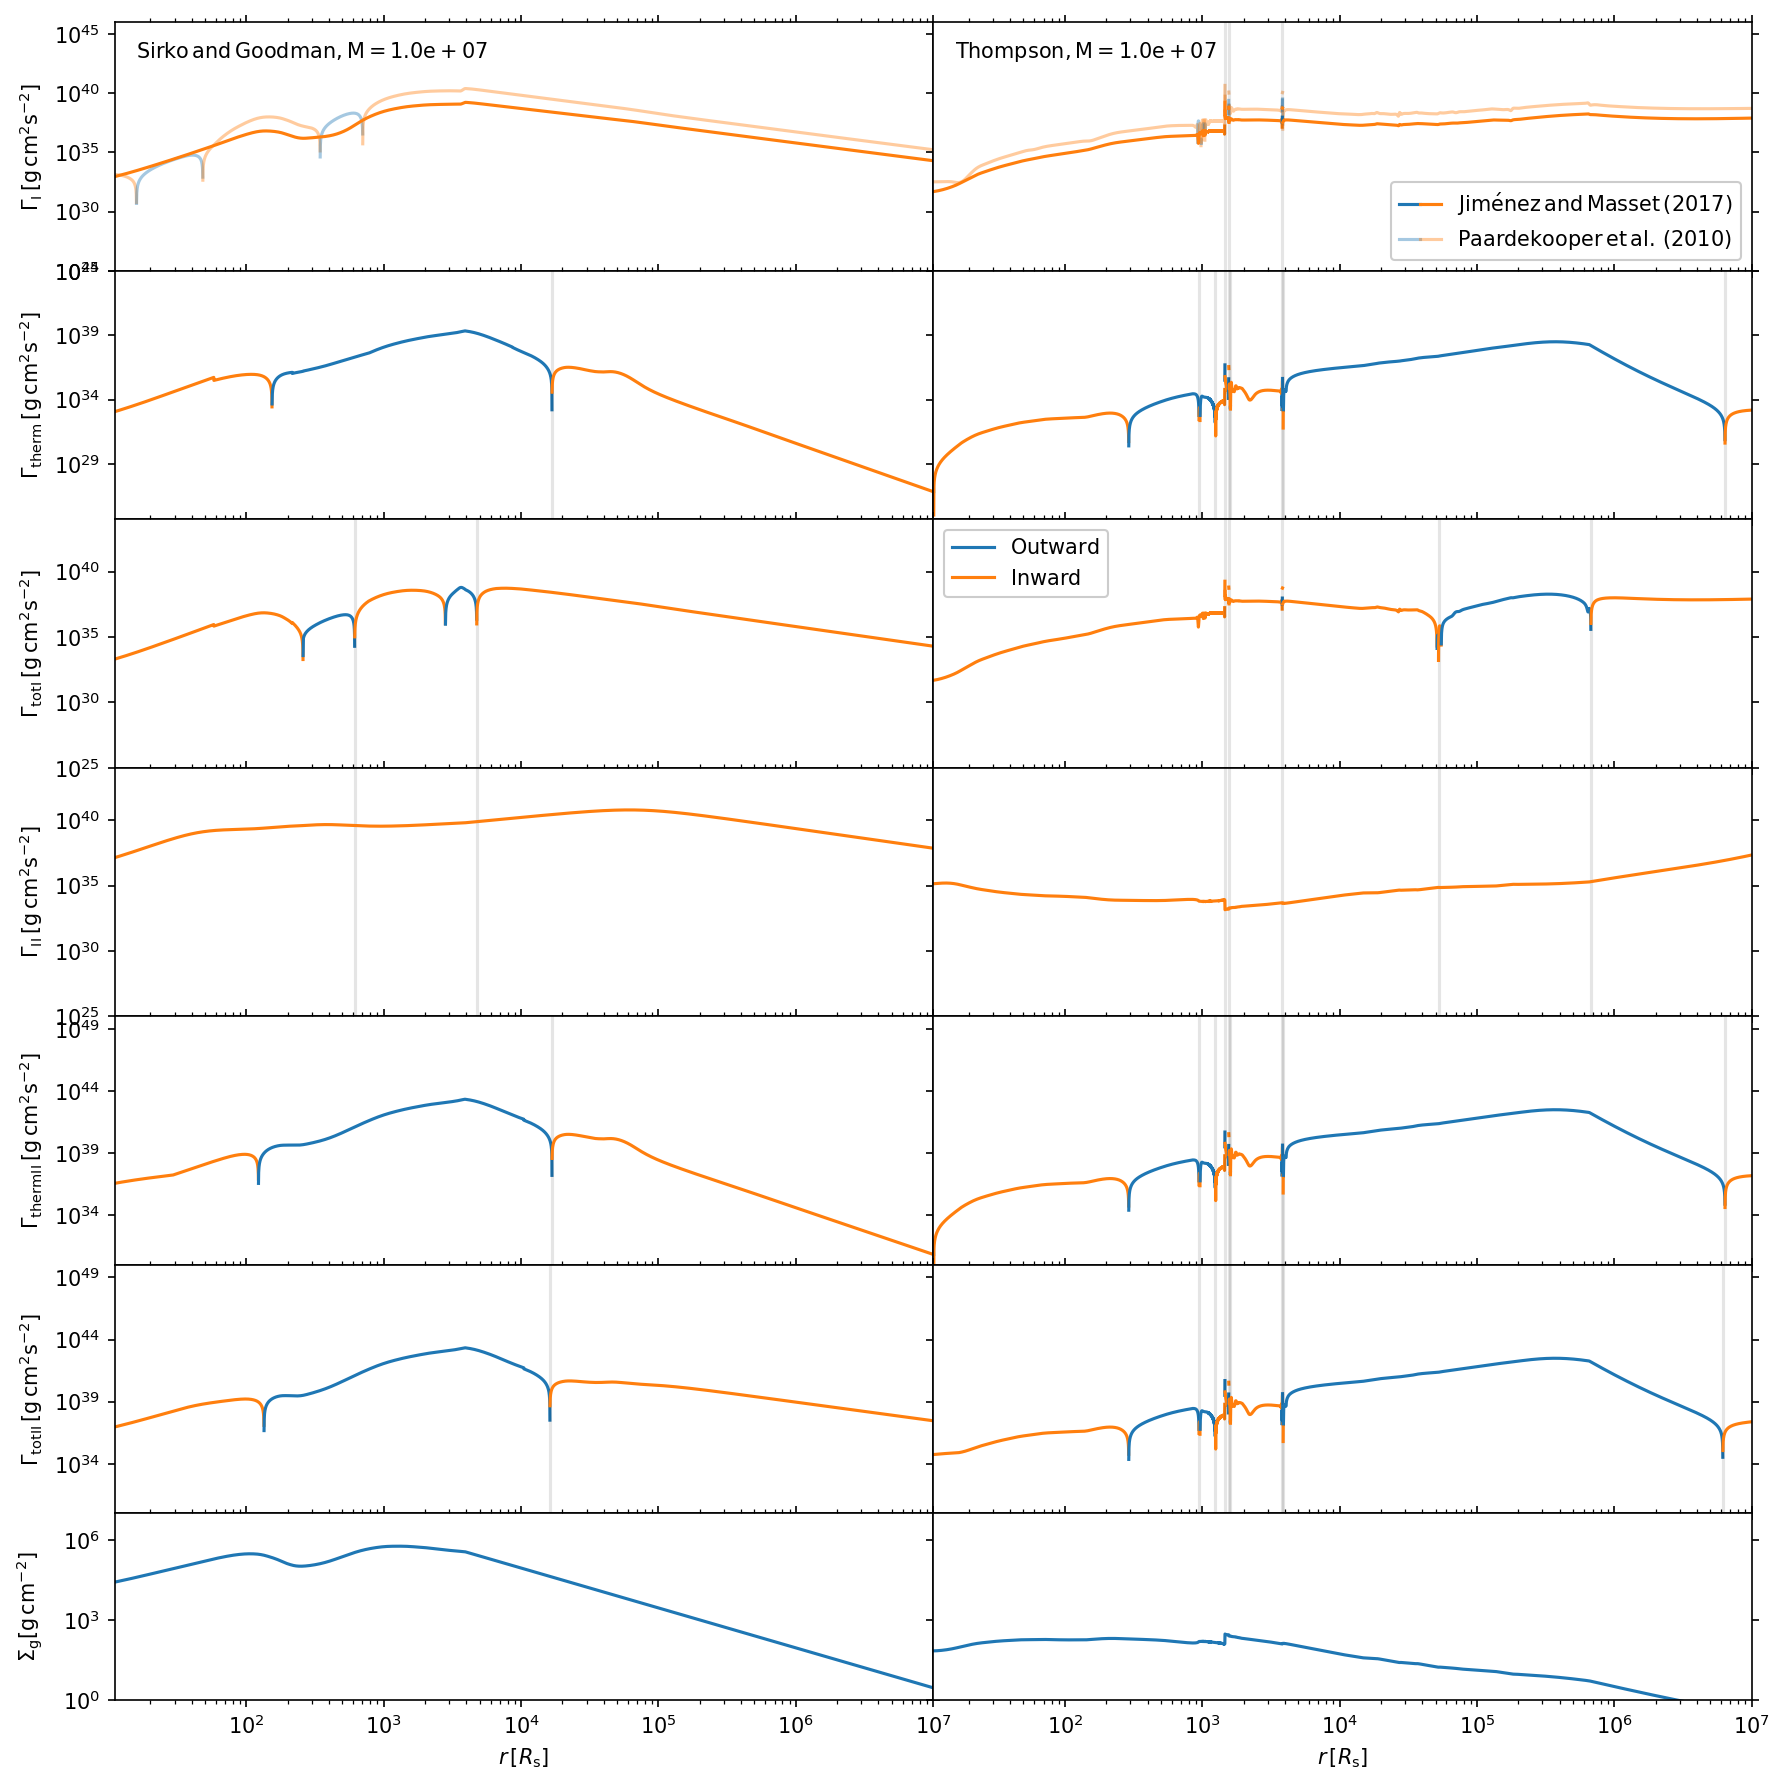

In [6]:
disk_name = ['sirko', 'thompson']
d_counter = 0

f, axes = plt.subplots(7, 2, figsize=(12, 12), sharex=True, sharey='row', gridspec_kw=dict(hspace=0, wspace =0, height_ratios = (2, 2, 2, 2, 2, 2, 1.5)), tight_layout=True)
for axx in axes.flatten():
    axx.set_yscale('log')
    axx.set_xscale('log')

for dname in disk_name:
    Mbh = 1e7
    q = 1e-6
    q_II = 1e-4

    #generate the disk values for both AGN disk models using pagn
    if dname == 'thompson':
        objin = Thompson.ThompsonAGN(Mbh = Mbh*ct.MSun, Mdot_out=0.,)
        rout = objin.Rs*(1e7)
        sigma = 200 * (Mbh / 1.3e8) ** (1 / 4.24)
        Mdot_out = 1.5e-2
        obj = Thompson.ThompsonAGN(Mbh=Mbh*ct.MSun, Rout = rout, Mdot_out=Mdot_out*ct.MSun/ct.yr)
        print('tho:', Mbh)
        clear_output(obj.solve_disk(N=1e4))
    else:
        le = 0.5
        alpha = 0.01
        obj = Sirko.SirkoAGN(Mbh=Mbh*ct.MSun, le=le, alpha=alpha, b=0)
        print('sk:', Mbh)
        clear_output(obj.solve_disk(N=1e4))

    Gamma_0 = gamma_0(q, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    #Grishin et al 2023 equations q=1e-6
    dSig = dSigmadR(obj)
    dT = dTdR(obj)
    cI_p10 = CI_p10(dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    gamma = 5/3
    print(np.mean(cI_p10))

    cI_jm_tot = CI_jm17_tot(dSig, dT, gamma, obj)
    Gamma_I_jm_tot = cI_jm_tot*Gamma_0
    Gamma_therm = gamma_thermal(gamma, obj, q)*Gamma_0*obj.R/obj.h
    print(np.mean(cI_jm_tot))
    
    Gamma_tot_I = Gamma_therm + Gamma_I_jm_tot
    
    #Gilbaum eq but for type II, so q=1e-4
    Gamma_0_II = gamma_0(q_II, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    Gamma_I_p10_II = cI_p10*Gamma_0_II
    gamma = 5/3

    Gamma_I_jm_tot_II = cI_jm_tot*Gamma_0_II
    Gamma_therm_II = gamma_thermal(gamma, obj, q_II)*Gamma_0_II*obj.R/obj.h
    
    c_II_gil = -1
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_gil = c_II_gil/cI_jm_tot*1/(1 + kappa)
    Gamma_II_gil = const_gil*Gamma_I_jm_tot_II
    
    
    #Kanagawa
    c_II_K = -0.4 
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_fact_K = c_II_K*1/(1 + kappa)
    
    Gamma_II_K = const_fact_K*Gamma_0_II

    
    Gamma_tot_II = Gamma_therm_II + Gamma_II_K

    #-----Plotting-----#


    linestyles = ['-', '--', '-.', ':']
    ax = axes[:, d_counter]
    if hasattr(obj, 'alpha'):
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Sirko \, and \, Goodman, M = 'f"{Mbh:.1e}"'}$' )
    else:
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Thompson, M = 'f"{Mbh:.1e}"'}$')

    for iGamma, Gamma in enumerate([Gamma_I_jm_tot, Gamma_therm, Gamma_tot_I, Gamma_II_gil, Gamma_therm_II, Gamma_tot_II]):
        maskg = Gamma >= 0
        indices = np.nonzero(maskg[1:] != maskg[:-1])[0] + 1
        Gammas = np.split(Gamma, indices)
        Rs = np.split(obj.R, indices)
        ignnum = 0
        ignum2 = 0
        for iseg, seg in enumerate(Gammas):
            if seg[0] < 0.:
                if Rs[iseg][0] / obj.Rs > ignnum + 40:
                    ax[iGamma].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color = 'k', alpha = 0.1)
                    ignnum = Rs[iseg][0] / obj.Rs

                ax[iGamma].plot(Rs[iseg]/obj.Rs, abs(seg)*ct.SI_to_gcm2, c='C1', zorder = 2)
                if iGamma == 2 and Rs[iseg][0] / obj.Rs > ignum2 + 40:
                    ax[3].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color='k', alpha=0.1)
                    ignum2 = Rs[iseg][0] / obj.Rs

            else:
                ax[iGamma].plot(Rs[iseg] / obj.Rs, abs(seg*ct.SI_to_gcm2) , c='C0', zorder = 2)
        if iGamma == 0:
            Gamma2 = Gamma_I_p10
            maskg2 = Gamma2 >= 0
            indices2 = np.nonzero(maskg2[1:] != maskg2[:-1])[0] + 1
            Gammas2 = np.split(Gamma2, indices2)
            Rs2 = np.split(obj.R, indices2)
            for iseg2, seg2 in enumerate(Gammas2):
                if seg2[0] < 0.:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C1', zorder = 1, alpha = 0.4)

                else:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C0', zorder = 1, alpha = 0.4)
    ax[6].plot(obj.R/obj.Rs, 2*obj.h*obj.rho*ct.SI_to_gcm2, label = r"$\Sigma_{\rm g} [{\rm g cm}^{-2}]$")
    d_counter += 1

pos_line = mlines.Line2D([], [], color='C0', marker='s',
                           markersize=0, label=r'$\rm{Outward}$')
neg_line = mlines.Line2D([], [], color='C1', marker='s',
                            markersize=0, label=r'$\rm{Inward}$')
artists_handles = [pos_line, neg_line]
axes[2, 1].legend(handles=artists_handles, framealpha = 1)

pos_line2 = mlines.Line2D([], [], color='C0', marker='s', alpha = 0.4,
                         markersize=0,)
neg_line2 = mlines.Line2D([], [], color='C1', marker='s', alpha = 0.4,
                         markersize=0,)


axes[0,1].legend(handles=[(pos_line, neg_line), (pos_line2, neg_line2,) ],
                 labels=[r'${\rm Jim \acute{e} nez \, and \, Masset \, (2017)}$', r'$\rm Paardekooper \, et \, al. \, (2010)$',],
                 handler_map = {tuple: HandlerTuple(ndivide = None, pad = 0.)},
                 framealpha = 1)

axes[0,0].set_ylabel(r'${\Gamma_{\rm I} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[1,0].set_ylabel(r'${\Gamma_{\rm therm} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[2,0].set_ylabel(r'${\Gamma_{\rm totI} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[3, 0].set_ylabel(r'${\Gamma_{\rm II} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[4,0].set_ylabel(r'${\Gamma_{\rm thermII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[5, 0].set_ylabel(r'${\Gamma_{\rm totII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[6, 0].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

x_label = r"$r \, [R_{\rm s}]$"
axes[6, 0].set_xlabel(x_label)
axes[6, 1].set_xlabel(x_label)

axes[0, 0].set_ylim((1e25, 1e46))

axes[1, 0].set_ylim((5e24, 1e44))

axes[2, 0].set_ylim((1e25, 1e44))

axes[3, 0].set_ylim((1e25, 1e44))

axes[4, 0].set_ylim((1e30, 1e50))

axes[5, 0].set_ylim((1e30, 1e50))

axes[6, 0].set_ylim((1e0, 1e7))

for axx in axes.flatten():
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.set_xlim((1e1, 1e7))
axes[0,1].set_xlim((1.1e1, 1e7))

f.align_ylabels()
plt.show()

# or maybe..
If now 

$$ \Gamma_{II} = \frac{C_{II}}{C_I} \frac{1}{1 + K/25} \Gamma_0 $$

in this way, if $C_I \sim -2.5$ from Jimenez and $C_{II} = 1 \rightarrow \frac{C_{II}}{C_I} \sim -0.4$ like the one used by Kanagawa.

-2.0559846314407593
-2.5477527963593025


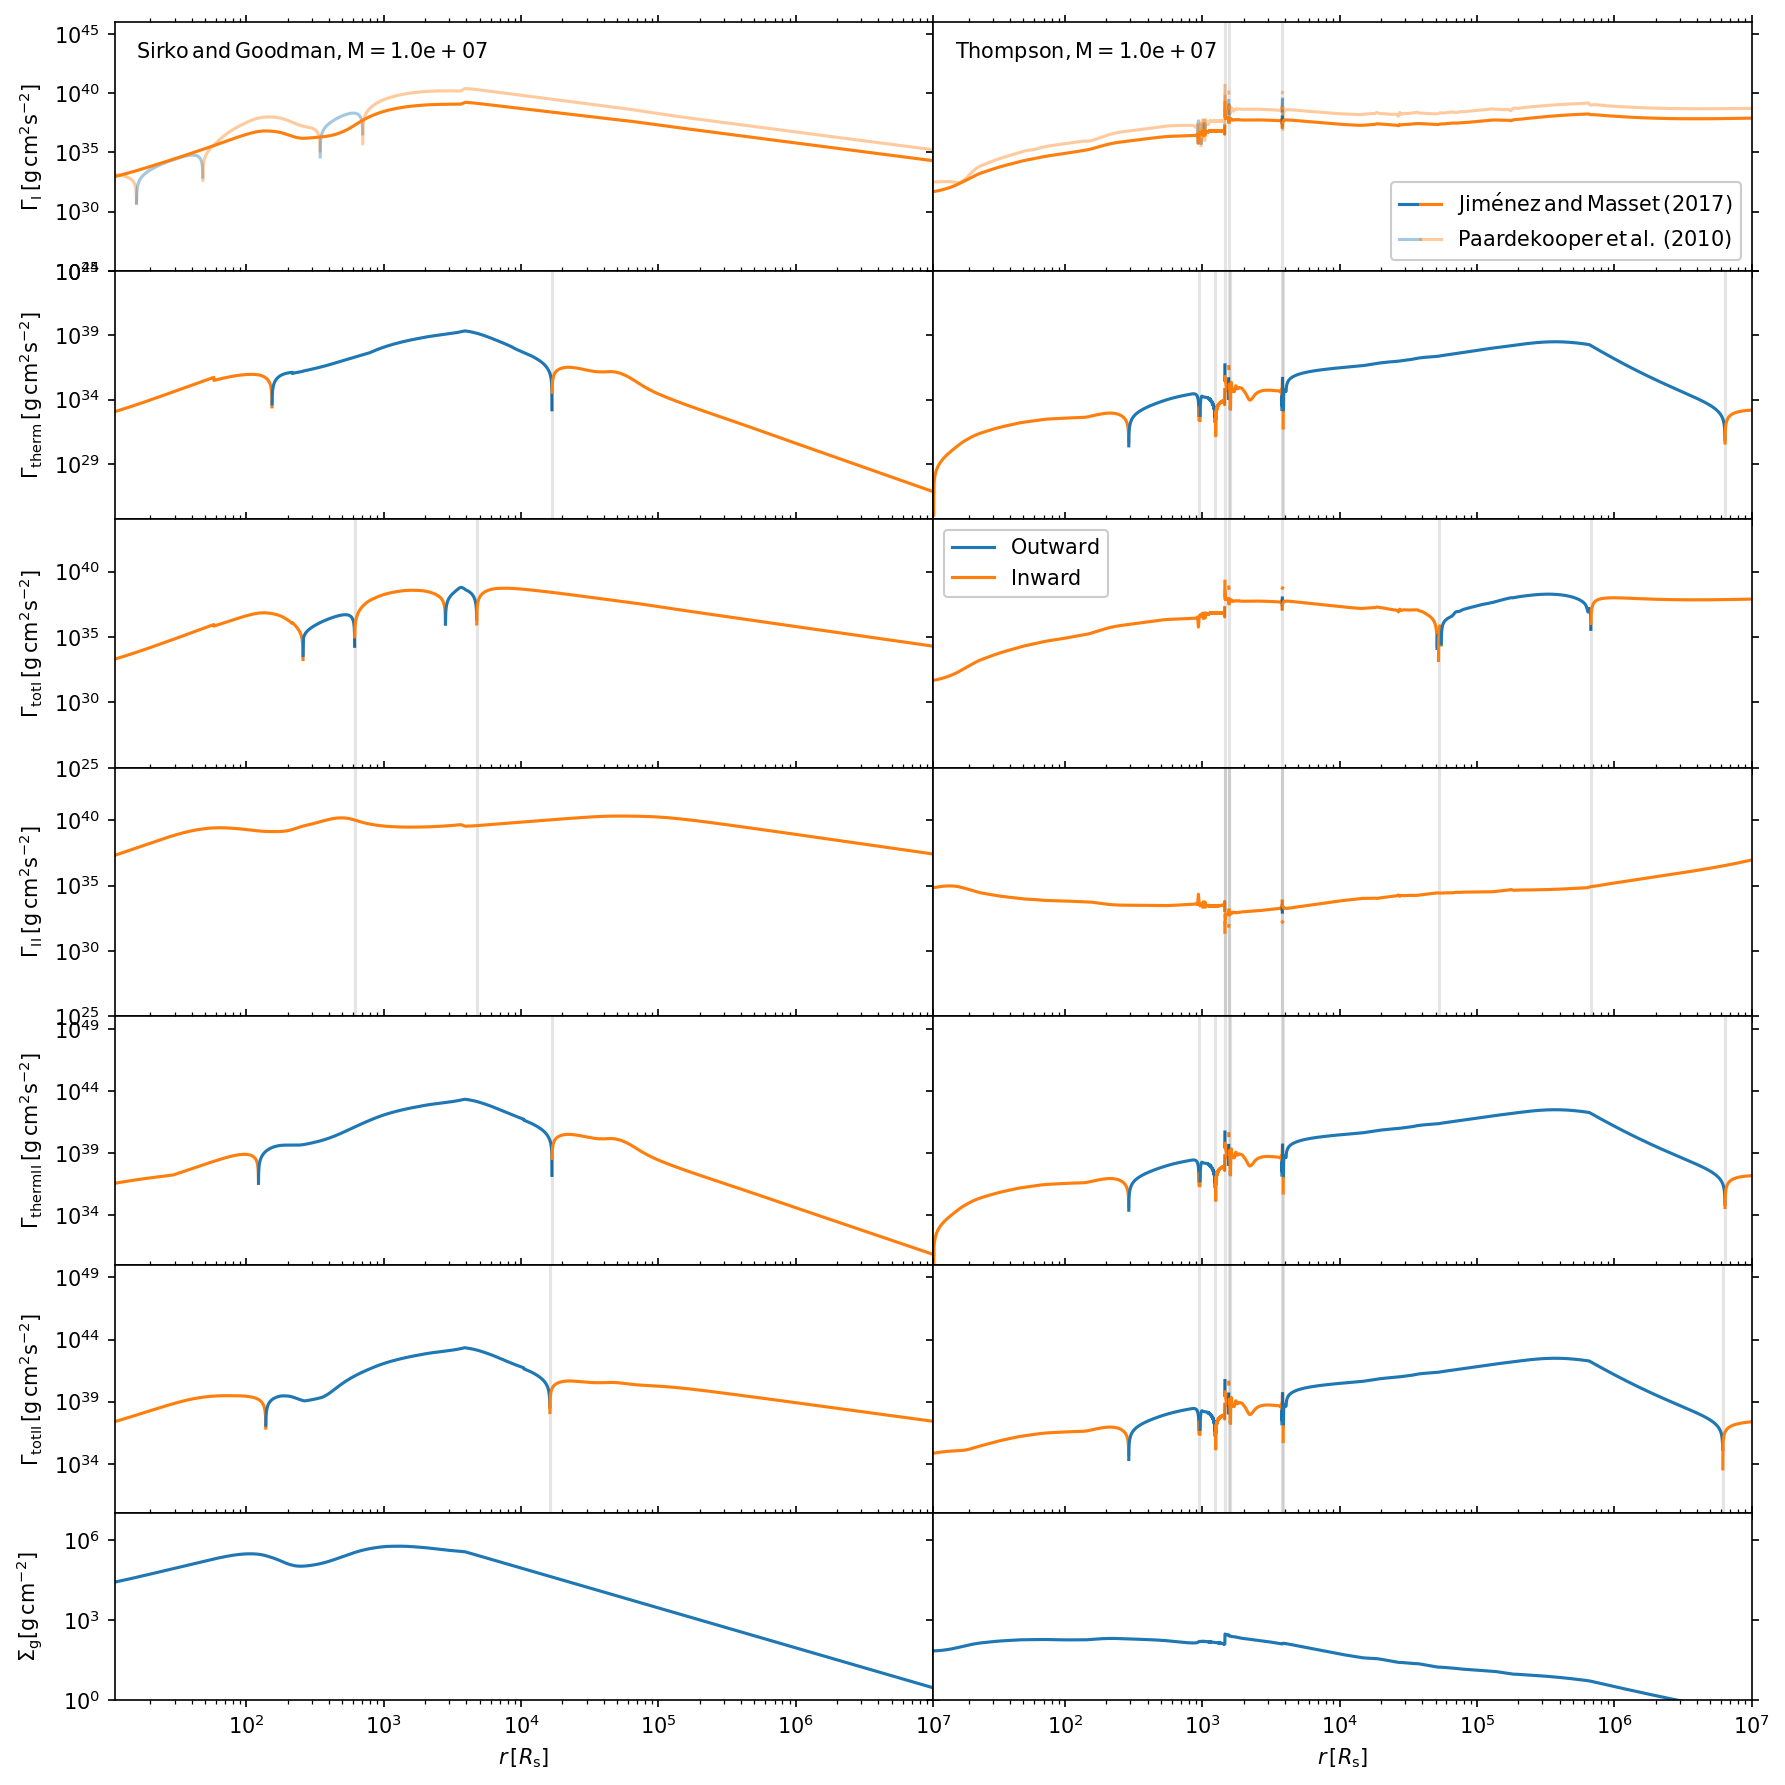

In [7]:
disk_name = ['sirko', 'thompson']
d_counter = 0

f, axes = plt.subplots(7, 2, figsize=(12, 12), sharex=True, sharey='row', gridspec_kw=dict(hspace=0, wspace =0, height_ratios = (2, 2, 2, 2, 2, 2, 1.5)), tight_layout=True)
for axx in axes.flatten():
    axx.set_yscale('log')
    axx.set_xscale('log')

for dname in disk_name:
    Mbh = 1e7
    q = 1e-6
    q_II = 1e-4

    #generate the disk values for both AGN disk models using pagn
    if dname == 'thompson':
        objin = Thompson.ThompsonAGN(Mbh = Mbh*ct.MSun, Mdot_out=0.,)
        rout = objin.Rs*(1e7)
        sigma = 200 * (Mbh / 1.3e8) ** (1 / 4.24)
        Mdot_out = 1.5e-2
        obj = Thompson.ThompsonAGN(Mbh=Mbh*ct.MSun, Rout = rout, Mdot_out=Mdot_out*ct.MSun/ct.yr)
        print('tho:', Mbh)
        clear_output(obj.solve_disk(N=1e4))
    else:
        le = 0.5
        alpha = 0.01
        obj = Sirko.SirkoAGN(Mbh=Mbh*ct.MSun, le=le, alpha=alpha, b=0)
        print('sk:', Mbh)
        clear_output(obj.solve_disk(N=1e4))

    Gamma_0 = gamma_0(q, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    #Grishin et al 2023 equations q=1e-6
    dSig = dSigmadR(obj)
    dT = dTdR(obj)
    cI_p10 = CI_p10(dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    gamma = 5/3
    print(np.mean(cI_p10))

    cI_jm_tot = CI_jm17_tot(dSig, dT, gamma, obj)
    Gamma_I_jm_tot = cI_jm_tot*Gamma_0
    Gamma_therm = gamma_thermal(gamma, obj, q)*Gamma_0*obj.R/obj.h
    print(np.mean(cI_jm_tot))
    
    Gamma_tot_I = Gamma_therm + Gamma_I_jm_tot
    
    #Gilbaum eq but for type II, so q=1e-4
    Gamma_0_II = gamma_0(q_II, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    Gamma_I_p10_II = cI_p10*Gamma_0_II
    gamma = 5/3

    Gamma_I_jm_tot_II = cI_jm_tot*Gamma_0_II
    Gamma_therm_II = gamma_thermal(gamma, obj, q_II)*Gamma_0_II*obj.R/obj.h
    
    c_II_gil = 1
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_gil = c_II_gil/cI_jm_tot*1/(1 + kappa)
    Gamma_II_gil = const_gil*Gamma_0_II
    
    
    #Kanagawa
    c_II_K = -0.4 
    kappa = Kappa(q_II, obj.h / obj.R, alpha )
    const_fact_K = c_II_K*1/(1 + kappa)
    
    Gamma_II_K = const_fact_K*Gamma_0_II

    
    Gamma_tot_II = Gamma_therm_II + Gamma_II_gil

    #-----Plotting-----#


    linestyles = ['-', '--', '-.', ':']
    ax = axes[:, d_counter]
    if hasattr(obj, 'alpha'):
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Sirko \, and \, Goodman, M = 'f"{Mbh:.1e}"'}$' )
    else:
        ax[0].text(10 ** 1.2, 10 ** 43,  r'${\rm Thompson, M = 'f"{Mbh:.1e}"'}$')

    for iGamma, Gamma in enumerate([Gamma_I_jm_tot, Gamma_therm, Gamma_tot_I, Gamma_II_gil, Gamma_therm_II, Gamma_tot_II]):
        maskg = Gamma >= 0
        indices = np.nonzero(maskg[1:] != maskg[:-1])[0] + 1
        Gammas = np.split(Gamma, indices)
        Rs = np.split(obj.R, indices)
        ignnum = 0
        ignum2 = 0
        for iseg, seg in enumerate(Gammas):
            if seg[0] < 0.:
                if Rs[iseg][0] / obj.Rs > ignnum + 40:
                    ax[iGamma].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color = 'k', alpha = 0.1)
                    ignnum = Rs[iseg][0] / obj.Rs

                ax[iGamma].plot(Rs[iseg]/obj.Rs, abs(seg)*ct.SI_to_gcm2, c='C1', zorder = 2)
                if iGamma == 2 and Rs[iseg][0] / obj.Rs > ignum2 + 40:
                    ax[3].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color='k', alpha=0.1)
                    ignum2 = Rs[iseg][0] / obj.Rs

            else:
                ax[iGamma].plot(Rs[iseg] / obj.Rs, abs(seg*ct.SI_to_gcm2) , c='C0', zorder = 2)
        if iGamma == 0:
            Gamma2 = Gamma_I_p10
            maskg2 = Gamma2 >= 0
            indices2 = np.nonzero(maskg2[1:] != maskg2[:-1])[0] + 1
            Gammas2 = np.split(Gamma2, indices2)
            Rs2 = np.split(obj.R, indices2)
            for iseg2, seg2 in enumerate(Gammas2):
                if seg2[0] < 0.:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C1', zorder = 1, alpha = 0.4)

                else:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C0', zorder = 1, alpha = 0.4)
    ax[6].plot(obj.R/obj.Rs, 2*obj.h*obj.rho*ct.SI_to_gcm2, label = r"$\Sigma_{\rm g} [{\rm g cm}^{-2}]$")
    d_counter += 1

pos_line = mlines.Line2D([], [], color='C0', marker='s',
                           markersize=0, label=r'$\rm{Outward}$')
neg_line = mlines.Line2D([], [], color='C1', marker='s',
                            markersize=0, label=r'$\rm{Inward}$')
artists_handles = [pos_line, neg_line]
axes[2, 1].legend(handles=artists_handles, framealpha = 1)

pos_line2 = mlines.Line2D([], [], color='C0', marker='s', alpha = 0.4,
                         markersize=0,)
neg_line2 = mlines.Line2D([], [], color='C1', marker='s', alpha = 0.4,
                         markersize=0,)


axes[0,1].legend(handles=[(pos_line, neg_line), (pos_line2, neg_line2,) ],
                 labels=[r'${\rm Jim \acute{e} nez \, and \, Masset \, (2017)}$', r'$\rm Paardekooper \, et \, al. \, (2010)$',],
                 handler_map = {tuple: HandlerTuple(ndivide = None, pad = 0.)},
                 framealpha = 1)

axes[0,0].set_ylabel(r'${\Gamma_{\rm I} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[1,0].set_ylabel(r'${\Gamma_{\rm therm} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[2,0].set_ylabel(r'${\Gamma_{\rm totI} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[3, 0].set_ylabel(r'${\Gamma_{\rm II} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[4,0].set_ylabel(r'${\Gamma_{\rm thermII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[5, 0].set_ylabel(r'${\Gamma_{\rm totII} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[6, 0].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

x_label = r"$r \, [R_{\rm s}]$"
axes[6, 0].set_xlabel(x_label)
axes[6, 1].set_xlabel(x_label)

axes[0, 0].set_ylim((1e25, 1e46))

axes[1, 0].set_ylim((5e24, 1e44))

axes[2, 0].set_ylim((1e25, 1e44))

axes[3, 0].set_ylim((1e25, 1e44))

axes[4, 0].set_ylim((1e30, 1e50))

axes[5, 0].set_ylim((1e30, 1e50))

axes[6, 0].set_ylim((1e0, 1e7))

for axx in axes.flatten():
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.set_xlim((1e1, 1e7))
axes[0,1].set_xlim((1.1e1, 1e7))

f.align_ylabels()
plt.show()